# Regularization and Optimization Lab

## Objective

In this lab, we'll gain experience detecting and dealing with a ANN model that is overfitting using various regularization and hyperparameter tuning techniques!

## Getting Started

In this lab, we'll work with a large dataset of customer complaints to a bank, with the goal of predicting what product the customer is complaining about based on the text of their complaint.  There are 7 different possible products that we can predict, making this a multi-class classification task. 


#### Preprocessing our Data Set
We'll start by preprocessing our dataset by tokenizing the complaints and limiting the number of words we consider to reduce dimensionality. 

#### Building our Tuning our Model
Once we have preprocessed our data set, we'll build a model and explore the various ways that we can reduce overfitting using the following strategies:
- Early stopping to minimize the discrepancy between train and test accuracy.
- L1 and L2 regularization.
- Dropout regularization.
- Using more data.


**_Let's Get Started!_**

## 2. Preprocessing the Bank Complaints Data Set

### 2.1 Import the libraries and take a sample

Run the cell below to import everything we'll need for this lab. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
import random
random.seed(0)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Now, in the cell below, import our data into a DataFrame.  The data is currently stored in `Bank_complaints.csv`.
Then, `.describe()` the dataset to get a feel for what we're working with. 

In [2]:
df =  pd.read_csv('Bank_complaints.csv')


In [3]:
df.head(1)

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...


In order to speed things up during the development process (and also to give us the ability to see how adding more data affects our model performance), we're going to work with a sample of our dataset rather than the whole thing.  The entire dataset consists of 60,000 rows--we're going to build a model using only 10,000 items randomly sampled from this.

In the cell below:

* Get a random sample of `10000` items from our dataset (HINT: use the `df` object's `.sample()` method to make this easy)
* Reset the indexes on these samples to `range(10000)`, so that the indices for our rows are sequential and make sense.
* Store our labels, which are found in `"Product"`, in a different variable.
* Store the data, found in `"Consumer complaint narrative`, in the variable `complaints`.

In [4]:
df = df.sample(10000)
df.index = range(10000)
product = df.Product
complaints = df['Consumer complaint narrative']

In [7]:
df.tail(1)

,Product,Consumer complaint narrative
9999,Credit reporting,A XXXX collection account placed on my credit ...


### 2.2 Tokenizing the Complaints

We'll only keep 2,000 most common words and use one-hot encoding to quickly vectorize our dataset from text into a format that a neural network can work with. 

In the cell below:

* Create a `Tokenizer()` object, and set the `num_words` parameter to `2000`.
* Call the tokenizer object's `fit_on_texts()` method and pass in our `complaints` variable we created above. 


In [10]:
# from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(complaints)

In [27]:
# print(tokenizer.word_counts)
# print(tokenizer.document_count)
# print(tokenizer.word_index)
# print(tokenizer.word_docs)
# word_counts: A dictionary of words and their counts.
# word_docs: A dictionary of words and how many documents each appeared in.
# word_index: A dictionary of words and their uniquely assigned integers.
# document_count:An integer count of the total number of documents that were used to fit the Tokenizer.

Now, we'll create some text sequences by calling the `tokenizer` object's `.texts_to_sequences()` method and feeding in our `complaints` object.

In [12]:
sequences = tokenizer.texts_to_sequences(complaints)

Finally, we'll convert our text data from text to a vectorized matrix.  

In the cell below:

* Call the `tokenizer` object's `.texts_to_matrix` method, passing in our `complaints` variable, as well as setting the `mode` parameter equal to `'binary'`.
* Store the tokenizer's `.word_index` in the appropriate variable.
* Check the `np.shape()` of our `one_hot_results`.

In [22]:
one_hot_results= tokenizer.texts_to_matrix(complaints, mode = 'binary')
word_index = tokenizer.word_index
np.shape(one_hot_results) # Expected Results (10000, 2000)

(10000, 2000)

### 2.3 One-hot Encoding of the Products Column

Now that we've tokenized and encoded our text data, we still need to one-hot encode our label data.  

In the cell below:


* Create a `LabelEncoder` object, which can found inside the `preprocessing` module.
* `fit` the label encoder we just created to `product`.

In [29]:
le = preprocessing.LabelEncoder()
le.fit(product)

LabelEncoder()

Let's check what classes our label encoder found.  Run the cell below to examine a list of classes that `product` contains.

In [30]:
 list(le.classes_)

['Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit reporting',
 'Mortgage',
 'Student loan']

Now, we'll need to transform `product` into a numeric vector.  

In the cell below, use the label encoder's `.transform` method on `product` to create an integer encoded version of our labels. 

Then, access `product_cat` to see an example of how the labels are now encoded. 

In [33]:
product_cat = le.transform(product)
product_cat

array([0, 6, 1, ..., 5, 6, 4])

Now, we need to go from integer encoding to one-hot encoding.  Use the `to_categorical` method from keras to do this easily in the cell below.

In [34]:
product_onehot = to_categorical(product_cat)

In [35]:
product_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

Finally, let's check the shape of our one-hot encoded labels to make sure everything worked correctly.

In [36]:
np.shape(product_onehot) # Expected Output: (10000, 7)

(10000, 7)

### 2.4 Train - test split

Now, we'll split our data into training and testing sets.  


We'll accomplish this by generating a random list of 1500 different indices between 1 and 10000.  Then, we'll slice these rows and store them as our test set, and delete them from the training set (it's very important to remember to remove them from the training set!)

Run the cell below to create a set of random indices for our test set. 

In [37]:
test_index = random.sample(range(1,10000), 1500)

Now:

* Slice the `test_index` rows from `one_hot_results` and store them in `test`.

In [39]:
test = one_hot_results[test_index]

# This line returns a version of our one_hot_results that has every item with an index in test_index removed
train = np.delete(one_hot_results, test_index, 0)

In [40]:
test

array([[0., 1., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

Now, we'll need to repeat the splitting process on our labels, making sure that we use the same indices we used to split our data. 

In the cell below:

* Slice `test_index` from `product_onehot`
* Use `np.delete` to remove `test_index` items from `product_onehot` (the syntax is exactly the same above)

In [41]:
label_test = product_onehot[test_index]
label_train = np.delete(product_onehot,test_index,0)

Now, let's examine the shape everything we just did to make sure that the dimensions match up.  

In the cell below, use `np.shape` to check the shape of:

* `label_test`
* `label_train`
* `test`
* `train`

In [42]:
print(np.shape(label_test)) # Expected Output: (1500, 7)
print(np.shape(label_train)) # Expected Output: (8500, 7)
print(np.shape(test)) # Expected Output: (1500, 2000)
print(np.shape(train)) # Expected Output: (8500, 2000)

(1500, 7)
(8500, 7)
(1500, 2000)
(8500, 2000)


## 3. Running the model using a validation set.

### 3.1 Creating the validation set

In the lecture we mentioned that in deep learning, we generally keep aside a validation set, which is used during hyperparameter tuning. Then when we have made the final model decision, the test set is used to define the final model perforance. 

In this example, let's take the first 1000 cases out of the training set to become the validation set. You should do this for both `train` and `label_train`.

Run the cell below to create our validation set. 

In [43]:
random.seed(123)
val = train[:1000]
train_final = train[1000:]
label_val = label_train[:1000]
label_train_final = label_train[1000:]

In [58]:
print(np.shape(val))
print(np.shape(train_final))
print(np.shape(label_val))
print(np.shape(label_train_final))

(1000, 2000)
(7500, 2000)
(1000, 7)
(7500, 7)


In [51]:
np.shape(val)

(1000, 2000)

### 3.2 Creating, compiling and running the model

Let's rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that we used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because we are dealing with a multiclass problem (classifying the complaints into 7 classes), we use a use a softmax classifyer in order to output 7 class probabilities per case.

In the cell below:

* Import `Sequential` from the appropriate module in keras.
* Import `Dense` from the appropriate module in keras.

In [44]:
from keras.models import Sequential
from keras.layers import Dense

Now, build a model with the following specifications in the cell below:

* An input layer of shape `(2000,)`
* Hidden layer 1: Dense, 50 neurons, relu activation 
* Hidden layer 2: Dense, 25 neurons, relu activation
* Output layer: Dense, 7 neurons, softmax activation

In [52]:
model = Sequential()
model.add(Dense(50,activation='relu', input_shape=(2000,))) 
model.add(Dense(25,activation='relu'))
model.add(Dense(7,activation='softmax'))

In the cell below, `compile` the model with the following settings:

* Optimizer is `"SGD"`
* Loss is `'categorical_crossentropy'`
* metrics is `['accuracy']`

In [53]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Now, Train the model for 120 epochs in mini-batches of 256 samples. Also pass in `(val, label_val)` to the `validation_data` parameter, so that we see how our model does on the test set after every epoch. 

In [54]:
model_val = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 3s 398us/step - loss: 1.9346 - acc: 0.1589 - val_loss: 1.9237 - val_acc: 0.1520
Epoch 2/120
7500/7500 [==============================] - 2s 288us/step - loss: 1.9126 - acc: 0.1924 - val_loss: 1.9034 - val_acc: 0.1830
Epoch 3/120
7500/7500 [==============================] - 2s 286us/step - loss: 1.8925 - acc: 0.2225 - val_loss: 1.8833 - val_acc: 0.2250
Epoch 4/120
7500/7500 [==============================] - 2s 286us/step - loss: 1.8716 - acc: 0.2555 - val_loss: 1.8629 - val_acc: 0.2620
Epoch 5/120
7500/7500 [==============================] - 2s 286us/step - loss: 1.8480 - acc: 0.2783 - val_loss: 1.8391 - val_acc: 0.2920
Epoch 6/120
7500/7500 [==============================] - 2s 286us/step - loss: 1.8207 - acc: 0.3117 - val_loss: 1.8115 - val_acc: 0.3140
Epoch 7/120
7500/7500 [==============================] - 2s 290us/step - loss: 1.7895 - acc: 0.3369 - val_loss: 1.7802 - val_acc: 

7500/7500 [==============================] - 2s 244us/step - loss: 0.5501 - acc: 0.8135 - val_loss: 0.6830 - val_acc: 0.7480
Epoch 61/120
7500/7500 [==============================] - 2s 239us/step - loss: 0.5451 - acc: 0.8155 - val_loss: 0.6761 - val_acc: 0.7500
Epoch 62/120
7500/7500 [==============================] - 2s 236us/step - loss: 0.5405 - acc: 0.8168 - val_loss: 0.6780 - val_acc: 0.7510
Epoch 63/120
7500/7500 [==============================] - 2s 238us/step - loss: 0.5354 - acc: 0.8175 - val_loss: 0.6848 - val_acc: 0.7480
Epoch 64/120
7500/7500 [==============================] - 2s 238us/step - loss: 0.5309 - acc: 0.8201 - val_loss: 0.6707 - val_acc: 0.7550
Epoch 65/120
7500/7500 [==============================] - 2s 238us/step - loss: 0.5261 - acc: 0.8211 - val_loss: 0.6698 - val_acc: 0.7540
Epoch 66/120
7500/7500 [==============================] - 2s 237us/step - loss: 0.5217 - acc: 0.8244 - val_loss: 0.6710 - val_acc: 0.7520
Epoch 67/120
7500/7500 [=======================

7500/7500 [==============================] - 2s 331us/step - loss: 0.3508 - acc: 0.8845 - val_loss: 0.6511 - val_acc: 0.7560
Epoch 120/120
7500/7500 [==============================] - 2s 314us/step - loss: 0.3489 - acc: 0.8837 - val_loss: 0.6498 - val_acc: 0.7600


The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In the cell below:

* Store the model's `.history` inside of `model_val_dict`
* Check what `keys()` this dictionary contains

In [55]:
model_val_dict = model_val.history
model_val_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Now, let's get the final results on the training and testing sets using `model.evaluate()` on `train_final` and `label_train_final`.

In [56]:
results_train = model.evaluate(train_final, label_train_final)

7500/7500 [==============================] - 2s 262us/step


Let's also use this function to get the results on our testing set.  Call the function again, but this time on `test` and `label_test`. 

In [59]:
results_test = model.evaluate(test, label_test)

1500/1500 [==============================] - 0s 303us/step


Now, check the contents of each. 

In [60]:
results_train # Expected Results: [0.33576024494171142, 0.89600000000000002]

[0.3448504872441292, 0.8893333333333333]

In [61]:
results_test # Expected Results: [0.72006658554077152, 0.74333333365122478]

[0.6270274307727813, 0.7593333333333333]

In [63]:
model_val_dict

{'val_loss': [1.923747929573059,
  1.903404146194458,
  1.8833405055999757,
  1.8629248723983765,
  1.8390928010940553,
  1.811545934677124,
  1.7802221660614013,
  1.7456075506210327,
  1.7062777719497682,
  1.6636336421966553,
  1.6161155662536622,
  1.5664185409545899,
  1.514007466316223,
  1.4607902345657349,
  1.4080764598846436,
  1.3574026412963867,
  1.308613842010498,
  1.2630957221984864,
  1.222189609527588,
  1.1819880418777466,
  1.1461393404006959,
  1.109346872329712,
  1.081881417274475,
  1.0503777275085449,
  1.0221461381912231,
  0.99610675907135,
  0.9694620456695556,
  0.9478779697418213,
  0.9282625575065613,
  0.9063040251731873,
  0.8884898209571839,
  0.8728558807373047,
  0.8569863328933716,
  0.8448549547195434,
  0.8320631852149963,
  0.8188950366973877,
  0.8075011076927185,
  0.7947821936607361,
  0.7862267265319824,
  0.7770417056083679,
  0.7682788643836975,
  0.7594435095787049,
  0.7548910655975342,
  0.744863525390625,
  0.7393947443962097,
  0.73612

### Plotting the results

Let's plot the results. Let's include the training and the validation loss in the same plot. We'll do the same thing for the training and validation accuracy.

Run the cell below to visualize a plot of our training and validation loss.

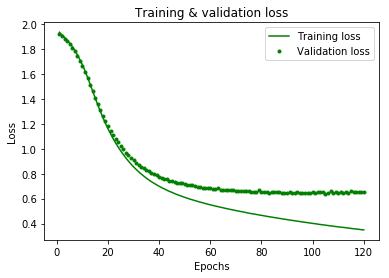

In [65]:
plt.clf()

import matplotlib.pyplot as plt
loss_values = model_val_dict['loss']
val_loss_values = model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'g.', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Interesting! 

Run the cell below to visualize a plot of our training and validation accuracy>

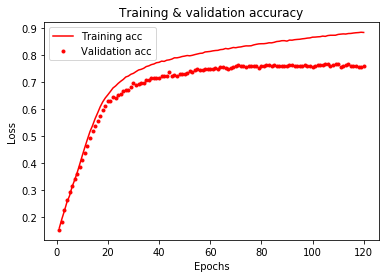

In [66]:
plt.clf()

acc_values = model_val_dict['acc'] 
val_acc_values = model_val_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We observe an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a status quo around the 60th epoch. This means that we're actually **overfitting** to the train data when we do as many epochs as we were doing. Luckily, you learned how to tackle overfitting in the previous lecture! For starters, it does seem clear that we are training too long. So let's stop training at the 60th epoch first (so-called "early stopping") before we move to more advanced regularization techniques!

## 3. Early stopping

Now that we know that the model starts to overfit around epoch 60, we can just retrain the model from scratch, but this time only up to 60 epochs! This will help us with our overfitting problem.  This method is called **_Early Stopping_**.

In the cell below: 

* Recreate the exact model we did above. 
* Compile the model with the exact same hyperparameters.
* Fit the model with the exact same hyperparameters, with the exception of `epochs`.  This time, set epochs to `60` instead of `120`.

In [67]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(Dense(25, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(train_final,
                    label_train_final,
                    epochs=60,
                    batch_size=256,
                    validation_data=(val, label_val))


Train on 7500 samples, validate on 1000 samples
Epoch 1/60
7500/7500 [==============================] - 3s 339us/step - loss: 1.9573 - acc: 0.1564 - val_loss: 1.9420 - val_acc: 0.1790
Epoch 2/60
7500/7500 [==============================] - 2s 311us/step - loss: 1.9289 - acc: 0.1921 - val_loss: 1.9207 - val_acc: 0.2010
Epoch 3/60
7500/7500 [==============================] - 2s 292us/step - loss: 1.9077 - acc: 0.2175 - val_loss: 1.9015 - val_acc: 0.2220
Epoch 4/60
7500/7500 [==============================] - 2s 302us/step - loss: 1.8862 - acc: 0.2333 - val_loss: 1.8793 - val_acc: 0.2350
Epoch 5/60
7500/7500 [==============================] - 2s 311us/step - loss: 1.8615 - acc: 0.2452 - val_loss: 1.8537 - val_acc: 0.2630
Epoch 6/60
7500/7500 [==============================] - 2s 331us/step - loss: 1.8318 - acc: 0.2715 - val_loss: 1.8214 - val_acc: 0.2770
Epoch 7/60
7500/7500 [==============================] - 2s 331us/step - loss: 1.7967 - acc: 0.2912 - val_loss: 1.7853 - val_acc: 0.3040


7500/7500 [==============================] - 3s 344us/step - loss: 0.5764 - acc: 0.8060 - val_loss: 0.7130 - val_acc: 0.7430


Now, as we did before, get our results using `model.evaluate()` on the appropriate variables. 

In [68]:
results_train = model.evaluate(train_final,label_train_final)

7500/7500 [==============================] - 2s 264us/step


In [69]:
results_test = model.evaluate(test, label_test)

1500/1500 [==============================] - 0s 292us/step


In [70]:
results_train  # Expected Output: [0.58606486314137773, 0.79826666669845581]

[0.5715655176957448, 0.8081333333651225]

In [71]:
results_test # [0.74768974288304646, 0.71333333365122475]

[0.6986736919085185, 0.7393333333333333]

We've significantly reduced the variance, so this is already pretty good! Our test set accuracy is slightly worse, but this model will definitely be more robust than the 120 epochs one we fitted before.

Now, let's see what else we can do to improve the result!

## 4. L2 regularization

Let's include L2 regularization. You can easily do this in keras adding the argument `kernel_regulizers.l2` and adding a value for the regularization parameter lambda between parentheses.

In the cell below: 

* Recreate the same model we did before.
* In our two hidden layers (but not our output layer), add in the parameter `kernel_regularizer=regularizers.l2(0.005)` to add L2 regularization to each hidden layer.  
* Compile the model with the same hyperparameters as we did before. 
* Fit the model with the same hyperparameters as we did before, but this time for `120` epochs.
* Store the fitted model that the `.fit` call returns inside a variable called `L2_model`.

In [72]:
from keras import regularizers
random.seed(123)
model = Sequential()
model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,))) #2 hidden layers
model.add(Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L2_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))



Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 3s 376us/step - loss: 2.6094 - acc: 0.1335 - val_loss: 2.5942 - val_acc: 0.1510
Epoch 2/120
7500/7500 [==============================] - 2s 293us/step - loss: 2.5797 - acc: 0.1519 - val_loss: 2.5717 - val_acc: 0.1670
Epoch 3/120
7500/7500 [==============================] - 2s 294us/step - loss: 2.5586 - acc: 0.1655 - val_loss: 2.5523 - val_acc: 0.1680
Epoch 4/120
7500/7500 [==============================] - 2s 292us/step - loss: 2.5387 - acc: 0.1849 - val_loss: 2.5333 - val_acc: 0.1880
Epoch 5/120
7500/7500 [==============================] - 2s 294us/step - loss: 2.5178 - acc: 0.2052 - val_loss: 2.5130 - val_acc: 0.2190
Epoch 6/120
7500/7500 [==============================] - 2s 293us/step - loss: 2.4952 - acc: 0.2385 - val_loss: 2.4902 - val_acc: 0.2480
Epoch 7/120
7500/7500 [==============================] - 2s 293us/step - loss: 2.4703 - acc: 0.2673 - val_loss: 2.4646 - val_acc: 

7500/7500 [==============================] - 2s 292us/step - loss: 1.1525 - acc: 0.7961 - val_loss: 1.2594 - val_acc: 0.7480
Epoch 61/120
7500/7500 [==============================] - 2s 292us/step - loss: 1.1448 - acc: 0.7973 - val_loss: 1.2523 - val_acc: 0.7410
Epoch 62/120
7500/7500 [==============================] - 2s 292us/step - loss: 1.1377 - acc: 0.7960 - val_loss: 1.2463 - val_acc: 0.7400
Epoch 63/120
7500/7500 [==============================] - 2s 292us/step - loss: 1.1306 - acc: 0.8005 - val_loss: 1.2401 - val_acc: 0.7470
Epoch 64/120
7500/7500 [==============================] - 3s 344us/step - loss: 1.1237 - acc: 0.7991 - val_loss: 1.2365 - val_acc: 0.7550
Epoch 65/120
7500/7500 [==============================] - 3s 348us/step - loss: 1.1168 - acc: 0.8032 - val_loss: 1.2327 - val_acc: 0.7550
Epoch 66/120
7500/7500 [==============================] - 3s 361us/step - loss: 1.1102 - acc: 0.8028 - val_loss: 1.2255 - val_acc: 0.7510
Epoch 67/120
7500/7500 [=======================

7500/7500 [==============================] - 2s 325us/step - loss: 0.8616 - acc: 0.8689 - val_loss: 1.0725 - val_acc: 0.7630
Epoch 120/120
7500/7500 [==============================] - 2s 319us/step - loss: 0.8580 - acc: 0.8719 - val_loss: 1.0719 - val_acc: 0.7640


Now, let's see how regularization has affected our model results.  

Run the cell below to get the model's `.history`.

In [73]:
L2_model_dict = L2_model.history
L2_model_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's look at the training accuracy as well as the validation accuracy for both the L2 and the model without regularization (for 120 epochs).

Run the cell below to visualize our training and validation accuracy both with and without L2 regularization, so that we can compare them directly.

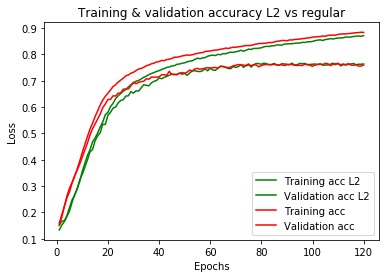

In [74]:
plt.clf()

acc_values = L2_model_dict['acc'] 
val_acc_values = L2_model_dict['val_acc']
model_acc = model_val_dict['acc']
model_val_acc = model_val_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L2')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc L2')
plt.plot(epochs, model_acc, 'r', label='Training acc')
plt.plot(epochs, model_val_acc, 'r', label='Validation acc')
plt.title('Training & validation accuracy L2 vs regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The results of L2 regularization are quite disappointing here. We notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better. 

## 5.  L1 regularization

Let's have a look at L1 regularization. Will this work better?

In the cell below: 

* Recreate the same model we did above, but this time, set the `kernel_regularizer` to `regularizers.l1(0.005)` inside both hidden layers. 
* Compile and fit the model exactly as we did for our L2 Regularization experiment (`120` epochs) 
* Store the fitted model that the `.fit` call returns inside a variable called `L1_model`.

In [75]:
model = Sequential()
model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 3s 388us/step - loss: 15.9829 - acc: 0.1499 - val_loss: 15.5729 - val_acc: 0.1700
Epoch 2/120
7500/7500 [==============================] - 2s 292us/step - loss: 15.2221 - acc: 0.1780 - val_loss: 14.8274 - val_acc: 0.2010
Epoch 3/120
7500/7500 [==============================] - 2s 294us/step - loss: 14.4838 - acc: 0.2095 - val_loss: 14.1022 - val_acc: 0.2320
Epoch 4/120
7500/7500 [==============================] - 2s 298us/step - loss: 13.7654 - acc: 0.2472 - val_loss: 13.3964 - val_acc: 0.2690
Epoch 5/120
7500/7500 [==============================] - 2s 296us/step - loss: 13.0659 - acc: 0.2797 - val_loss: 12.7093 - val_acc: 0.3000
Epoch 6/120
7500/7500 [==============================] - 2s 295us/step - loss: 12.3848 - acc: 0.3164 - val_loss: 12.0406 - val_acc: 0.3500
Epoch 7/120
7500/7500 [==============================] - 2s 304us/step - loss: 11.7223 - acc: 0.3584 - val_loss: 11.39

Epoch 60/120
7500/7500 [==============================] - 2s 332us/step - loss: 1.7298 - acc: 0.6849 - val_loss: 1.7755 - val_acc: 0.6540
Epoch 61/120
7500/7500 [==============================] - 2s 319us/step - loss: 1.7207 - acc: 0.6843 - val_loss: 1.7669 - val_acc: 0.6530
Epoch 62/120
7500/7500 [==============================] - 2s 319us/step - loss: 1.7112 - acc: 0.6853 - val_loss: 1.7716 - val_acc: 0.6470
Epoch 63/120
7500/7500 [==============================] - 2s 321us/step - loss: 1.7028 - acc: 0.6843 - val_loss: 1.7474 - val_acc: 0.6600
Epoch 64/120
7500/7500 [==============================] - 2s 311us/step - loss: 1.6929 - acc: 0.6880 - val_loss: 1.7388 - val_acc: 0.6630
Epoch 65/120
7500/7500 [==============================] - 2s 296us/step - loss: 1.6847 - acc: 0.6879 - val_loss: 1.7306 - val_acc: 0.6570
Epoch 66/120
7500/7500 [==============================] - 2s 302us/step - loss: 1.6752 - acc: 0.6904 - val_loss: 1.7238 - val_acc: 0.6600
Epoch 67/120
7500/7500 [==========

7500/7500 [==============================] - 2s 253us/step - loss: 1.3397 - acc: 0.7165 - val_loss: 1.3921 - val_acc: 0.6890
Epoch 120/120
7500/7500 [==============================] - 2s 250us/step - loss: 1.3350 - acc: 0.7164 - val_loss: 1.3851 - val_acc: 0.6870


Now, run the cell below to get and visualize the model's `.history`.

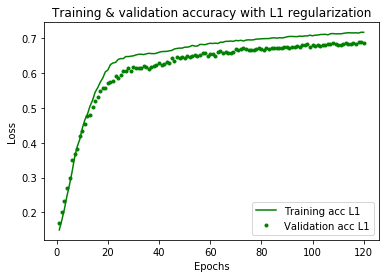

In [76]:
L1_model_dict = L1_model.history
plt.clf()

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L1')
plt.plot(epochs, val_acc_values, 'g.', label='Validation acc L1')
plt.title('Training & validation accuracy with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notice how The training and validation accuracy don't diverge as much as before! Unfortunately, the validation accuracy doesn't reach rates much higher than 70%. It does seem like we can still improve the model by training much longer.

To complete our comparison, let's use `model.evaluate()` again on the appropriate variables to compare results. 

In [77]:
results_train = model.evaluate(train_final, label_train_final)

results_test = model.evaluate(test, label_test)

1500/1500 [==============================] - 0s 276us/step


In [78]:
results_train # Expected Output: [1.3186310468037923, 0.72266666663487755]

[1.334806237188975, 0.7164]

In [79]:
results_test # Expected Output: [1.3541648308436076, 0.70800000031789145]

[1.3708883482615153, 0.7026666666666667]

This is about the best we've seen so far, but we were training for quite a while! Let's see if dropout regularization can do even better and/or be more efficient!

## 6. Dropout Regularization

Dropout Regularization is accomplished by adding in an additional `Dropout` layer wherever we want to use it, and providing a percentage value for how likely any given neuron is to get "dropped out" during this layer. 

In the cell below:

* Import `Dropout` from `keras.layers`
* Recreate the same network we have above, but this time without any L1 or L2 regularization
* Add a `Dropout` layer between hidden layer 1 and hidden layer 2.  This should have a dropout chance of `0.3`.
* Add a `Dropout` layer between hidden layer 2 and the output layer.  This should have a dropout chance of `0.3`.
* Compile the model with the exact same hyperparameters as all other models we've built. 
* Fit the model with the same hyperparameters we've used above.  But this time, train the model for `200` epochs. 

In [80]:
from keras.layers import Dropout
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(Dropout(0.3))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout_model = model.fit(train_final,
                    label_train_final,
                    epochs=200,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/200
7500/7500 [==============================] - 3s 401us/step - loss: 1.9785 - acc: 0.1415 - val_loss: 1.9415 - val_acc: 0.1650
Epoch 2/200
7500/7500 [==============================] - 2s 328us/step - loss: 1.9480 - acc: 0.1603 - val_loss: 1.9209 - val_acc: 0.1870
Epoch 3/200
7500/7500 [==============================] - 3s 339us/step - loss: 1.9292 - acc: 0.1793 - val_loss: 1.9043 - val_acc: 0.2110
Epoch 4/200
7500/7500 [==============================] - 3s 341us/step - loss: 1.9188 - acc: 0.1859 - val_loss: 1.8883 - val_acc: 0.2160
Epoch 5/200
7500/7500 [==============================] - 3s 341us/step - loss: 1.8996 - acc: 0.2035 - val_loss: 1.8730 - val_acc: 0.2300
Epoch 6/200
7500/7500 [==============================] - 3s 348us/step - loss: 1.8861 - acc: 0.2160 - val_loss: 1.8573 - val_acc: 0.2420
Epoch 7/200
7500/7500 [==============================] - 2s 311us/step - loss: 1.8732 - acc: 0.2253 - val_loss: 1.8420 - val_acc: 

7500/7500 [==============================] - 2s 312us/step - loss: 1.0304 - acc: 0.6132 - val_loss: 0.8833 - val_acc: 0.7190
Epoch 61/200
7500/7500 [==============================] - 2s 291us/step - loss: 1.0255 - acc: 0.6207 - val_loss: 0.8748 - val_acc: 0.7180
Epoch 62/200
7500/7500 [==============================] - 2s 287us/step - loss: 1.0180 - acc: 0.6169 - val_loss: 0.8672 - val_acc: 0.7260
Epoch 63/200
7500/7500 [==============================] - 2s 294us/step - loss: 1.0112 - acc: 0.6219 - val_loss: 0.8600 - val_acc: 0.7280
Epoch 64/200
7500/7500 [==============================] - 2s 280us/step - loss: 1.0010 - acc: 0.6276 - val_loss: 0.8547 - val_acc: 0.7230
Epoch 65/200
7500/7500 [==============================] - 2s 261us/step - loss: 0.9893 - acc: 0.6333 - val_loss: 0.8479 - val_acc: 0.7280
Epoch 66/200
7500/7500 [==============================] - 2s 270us/step - loss: 0.9739 - acc: 0.6399 - val_loss: 0.8409 - val_acc: 0.7310
Epoch 67/200
7500/7500 [=======================

7500/7500 [==============================] - 2s 247us/step - loss: 0.7315 - acc: 0.7313 - val_loss: 0.6738 - val_acc: 0.7470
Epoch 120/200
7500/7500 [==============================] - 2s 247us/step - loss: 0.7255 - acc: 0.7273 - val_loss: 0.6744 - val_acc: 0.7490
Epoch 121/200
7500/7500 [==============================] - 2s 249us/step - loss: 0.7289 - acc: 0.7252 - val_loss: 0.6722 - val_acc: 0.7490
Epoch 122/200
7500/7500 [==============================] - 2s 246us/step - loss: 0.7130 - acc: 0.7296 - val_loss: 0.6695 - val_acc: 0.7520
Epoch 123/200
7500/7500 [==============================] - 2s 247us/step - loss: 0.7055 - acc: 0.7323 - val_loss: 0.6688 - val_acc: 0.7530
Epoch 124/200
7500/7500 [==============================] - 2s 249us/step - loss: 0.7132 - acc: 0.7372 - val_loss: 0.6684 - val_acc: 0.7490
Epoch 125/200
7500/7500 [==============================] - 2s 247us/step - loss: 0.6971 - acc: 0.7383 - val_loss: 0.6664 - val_acc: 0.7480
Epoch 126/200
7500/7500 [================

7500/7500 [==============================] - 2s 247us/step - loss: 0.5799 - acc: 0.7803 - val_loss: 0.6324 - val_acc: 0.7550
Epoch 179/200
7500/7500 [==============================] - 2s 246us/step - loss: 0.5833 - acc: 0.7747 - val_loss: 0.6319 - val_acc: 0.7600
Epoch 180/200
7500/7500 [==============================] - 2s 246us/step - loss: 0.5835 - acc: 0.7656 - val_loss: 0.6319 - val_acc: 0.7590
Epoch 181/200
7500/7500 [==============================] - 2s 246us/step - loss: 0.5849 - acc: 0.7700 - val_loss: 0.6320 - val_acc: 0.7580
Epoch 182/200
7500/7500 [==============================] - 2s 246us/step - loss: 0.5791 - acc: 0.7715 - val_loss: 0.6323 - val_acc: 0.7570
Epoch 183/200
7500/7500 [==============================] - 2s 246us/step - loss: 0.5721 - acc: 0.7789 - val_loss: 0.6317 - val_acc: 0.7570
Epoch 184/200
7500/7500 [==============================] - 2s 245us/step - loss: 0.5708 - acc: 0.7771 - val_loss: 0.6311 - val_acc: 0.7560
Epoch 185/200
7500/7500 [================

Now, let's check the results from `model.evaluate` to see how this change has affected our training. 

In [81]:
results_train = model.evaluate(train_final, label_train_final)
results_test = model.evaluate(test, label_test)

1500/1500 [==============================] - 0s 244us/step


In [82]:
results_train # Expected Results: [0.36925017188787462, 0.88026666666666664]

[0.3844145245234172, 0.8393333333333334]

In [83]:
results_test # Expected Results: [0.69210424280166627, 0.74333333365122478]

[0.6138144634564717, 0.7546666671435038]

You can see here that the validation performance has improved again! However, the variance did become higher again, compared to L1-regularization.

## 7.  More Training Data?

Another solution to high variance is to just get more data. We actually *have* more data, but took a subset of 10,000 units before. Let's now quadruple our data set, and see what happens. Note that we are really just lucky here, and getting more data isn't always possible, but this is a useful exercise in order to understand the power of big data sets.

Run the cell below to preprocess our entire dataset, instead of just working with a subset of the data.  

In [84]:
df = pd.read_csv('Bank_complaints.csv')
random.seed(123)
df = df.sample(40000)
df.index = range(40000)
product = df["Product"]
complaints = df["Consumer complaint narrative"]

#one-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(complaints)
sequences = tokenizer.texts_to_sequences(complaints)
one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary')
word_index = tokenizer.word_index
np.shape(one_hot_results)

#one-hot encoding of products
le = preprocessing.LabelEncoder()
le.fit(product)
list(le.classes_)
product_cat = le.transform(product) 
product_onehot = to_categorical(product_cat)

# train test split
test_index = random.sample(range(1,40000), 4000)
test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)
label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

#Validation set
random.seed(123)
val = train[:3000]
train_final = train[3000:]
label_val = label_train[:3000]
label_train_final = label_train[3000:]

Now, build the first model that we built, without any regularization or dropout layers included. 

Train this model for 120 epochs.  All other hyperparameters should stay the same.  Store the fitted model inside of `moredata_model`.  

In [85]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(Dense(25, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moredata_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 33000 samples, validate on 3000 samples
Epoch 1/120
33000/33000 [==============================] - 9s 268us/step - loss: 1.9247 - acc: 0.1887 - val_loss: 1.8788 - val_acc: 0.2557
Epoch 2/120
33000/33000 [==============================] - 8s 237us/step - loss: 1.8282 - acc: 0.3059 - val_loss: 1.7599 - val_acc: 0.3567
Epoch 3/120
33000/33000 [==============================] - 8s 246us/step - loss: 1.6769 - acc: 0.4045 - val_loss: 1.5805 - val_acc: 0.4603
Epoch 4/120
33000/33000 [==============================] - 8s 235us/step - loss: 1.4787 - acc: 0.5143 - val_loss: 1.3765 - val_acc: 0.5583
Epoch 5/120
33000/33000 [==============================] - 8s 237us/step - loss: 1.2810 - acc: 0.6035 - val_loss: 1.1919 - val_acc: 0.6377
Epoch 6/120
33000/33000 [==============================] - 8s 236us/step - loss: 1.1122 - acc: 0.6558 - val_loss: 1.0449 - val_acc: 0.6777
Epoch 7/120
33000/33000 [==============================] - 8s 242us/step - loss: 0.9821 - acc: 0.6875 - val_loss: 0.9

33000/33000 [==============================] - 9s 268us/step - loss: 0.4123 - acc: 0.8557 - val_loss: 0.5075 - val_acc: 0.8183
Epoch 60/120
33000/33000 [==============================] - 9s 276us/step - loss: 0.4098 - acc: 0.8558 - val_loss: 0.5093 - val_acc: 0.8183
Epoch 61/120
33000/33000 [==============================] - 10s 299us/step - loss: 0.4080 - acc: 0.8562 - val_loss: 0.5097 - val_acc: 0.8180
Epoch 62/120
33000/33000 [==============================] - 9s 277us/step - loss: 0.4059 - acc: 0.8574 - val_loss: 0.5066 - val_acc: 0.8173
Epoch 63/120
33000/33000 [==============================] - 8s 241us/step - loss: 0.4033 - acc: 0.8594 - val_loss: 0.5065 - val_acc: 0.8187
Epoch 64/120
33000/33000 [==============================] - 8s 238us/step - loss: 0.4009 - acc: 0.8599 - val_loss: 0.5077 - val_acc: 0.8180
Epoch 65/120
33000/33000 [==============================] - 8s 230us/step - loss: 0.3992 - acc: 0.8604 - val_loss: 0.5076 - val_acc: 0.8193
Epoch 66/120
33000/33000 [======

33000/33000 [==============================] - 8s 229us/step - loss: 0.3203 - acc: 0.8896 - val_loss: 0.5301 - val_acc: 0.8167
Epoch 118/120
33000/33000 [==============================] - 8s 234us/step - loss: 0.3188 - acc: 0.8909 - val_loss: 0.5331 - val_acc: 0.8140
Epoch 119/120
33000/33000 [==============================] - 9s 269us/step - loss: 0.3173 - acc: 0.8913 - val_loss: 0.5336 - val_acc: 0.8153
Epoch 120/120
33000/33000 [==============================] - 10s 295us/step - loss: 0.3162 - acc: 0.8904 - val_loss: 0.5339 - val_acc: 0.8190


Now, finally, let's check the results returned from `model.evaluate()` to see how this model stacks up with the other techniques we've used.  

In [86]:
results_train = model.evaluate(train_final, label_train_final)
results_test = model.evaluate(test, label_test)

4000/4000 [==============================] - 1s 290us/step


In [87]:
results_train # Expected Output:  [0.31160746300942971, 0.89160606060606062]

[0.3118883702303424, 0.8932727272727272]

In [88]:
results_test # Expected Output: [0.56076071488857271, 0.8145]

[0.5888206927776337, 0.7995]

With the same amount of epochs, we were able to get a fairly similar validation accuracy of 89.1%. Our test set accuracy went up from ~75% to a staggering 81.45% though, without any other regularization technique. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance!

## Sources

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb

https://catalog.data.gov/dataset/consumer-complaint-database

## Further reading

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/